### Autoencoder

In this notebook we will see the application of a deep autoencoder architecture to the Fashion MNIST dataset.

In [ ]:
# uncomment this just the first time to download the following library inside the ml_venv
"""
! pip install tqdm
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from scratch_libraries.autoencoder_nn import Autoencoder

from sklearn.svm import SVC
from sklearn.metrics import classification_report

from tqdm import tqdm # it's a library that is used to show a progress bar during training

In [2]:
# Uncomment the following line if you're using macOS with Apple Silicon:
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 100
latent_dim = 64

The **MNIST** dataset is a widely used benchmark dataset for training and evaluating machine/deep learning models, particularly in image classification tasks. It consists of grayscale images of handwritten digits (0–9), each of size 28x28 pixels. A modern variant, **FashionMNIST**, replaces the digit images with images of **10 categories of fashion items** (e.g., shirts, trousers, and shoes), providing a more contemporary challenge. The same **28x28 format** is kept.

Below is a typical preprocessing pipeline for training machine learning models on image datasets like FashionMNIST:

1. **Transformation Pipeline**:
    - `ToTensor()`: This method converts a PIL Image or ndarray to tensor and scale the values accordingly.
    Specifically it converts the pixel values of our image from the original range `[0, 255]` to a `torch.FloatTensor` of range `[0.0, 1.0]`.

        For example, a pixel value of 128 would become $ 128 / 255 = 0.50196 $
        
        Thus, after `ToTensor()`, the resulting image tensor will have values in the range `[0, 1]`.

    - `Normalize((0.5,), (0.5,))`: This normalization step shifts of $0.5$ and scales of $0.5$ the tensor values so that the resulting tensor values will have a mean of $0$ and a standard deviation of $1$. Infact let's consider of the min and max values are transformed:
        
        A value of 0.0 becomes:
            $$ (0.0 - 0.5)/0.5 = -1 $$
        A value of 1.0 becomes:
            $$ (1.0 - 0.5)/0.5 = 1 $$
        So after `Normalize((0.5,), (0.5,))`, the tensor values are scaled in the range `[-1, 1]`. This ensures better training stability and so as consequence faster convergence.
    

2. **Dataset Creation**: The `datasets.FashionMNIST` function is used to download and load the FashionMNIST dataset, creating two subsets:

    - **train_dataset**: For training the model.
    - **test_dataset**: For evaluating the model's performance on unseen data.

    The defined transformations (tensor conversion and normalization) are applied during the dataset loading process.

3. **DataLoader**: They handle batching and shuffling efficiently:
    - **train_loader**: Loads training data in batches of size batch_size and shuffles it to introduce randomness, aiding generalization.
    - **test_loader**: Loads testing data in batches without shuffling, ensuring consistent evaluation results.

This preprocessing setup ensures the dataset is ready for efficient and stable training and evaluation of machine learning models.


In [8]:
# Data preprocessing: convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(
    root="./datasets", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./datasets", train=False, download=True, transform=transform
)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Recall that **Autoencoders** are a type of artificial neural network primarily used for dimensionality reduction. The main goal of autoencoders is to learn a lower-dimensional representation of input data which is able to maintain the most important information.

In this case we will implement a **Deep autoencoder** (an autoencoder with multiple hidden layers) to learn a compressed representation of Fashion MNIST images ($28 \times 28$ grayscale images).

The network consists of two main blocks:
1. **Encoder**: The encoder compresses the input image into a lower-dimensional representation, known as the **latent representation**.

    - The input image, flattened into a vector of size $28 \times 28 = 784$, passes through three fully connected layers with dimensions 256, 128, and finally the latent dimension ($latent\_dim$).
    - The final encoder layer outputs a latent representation of the input image. This is the "bottleneck" where the most crucial features of the input image are stored in a lower-dimensional form.

2. **Decoder**: The decoder reconstructs the original image from the latent representation.

    - The latent vector is passed through three fully connected layers with dimensions: $latent\_dim \to 128 \to 256 \to 784$.
        - **Note**: Very often the structure of the decoder layers is **specular** to the encoder's layers (as in this case), meaning that the number of units in each decoder layer mirrors the dimensions of the encoder layers in reverse order.
    - A **sigmoid** activation function is applied in the final layer to ensure the reconstructed pixel values are in the range $[0, 1]$ (aligning with the pixel intensity range of the input images).
    - The reconstructed image is then reshaped back to its original dimensions of $28 \times 28$.


This deep autoencoder has **6 hidden layers** in total, 3 layers in the encoder and 3 layers in the decoder. The **latent representation dimension** ($latent\_dim$) is an hyperparameter of our model.

By training the autoencoder, the model learns to minimize the **reconstruction error**, effectively "compressing" in a lower-dimensional space the input while preserving the essential structure of the data.


In [9]:
# Model, Loss, Optimizer
model = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Autoencoder Training Loop
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, images.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

  1%|          | 1/100 [00:18<30:17, 18.36s/it]

Epoch [1/100], Loss: 0.6476


  2%|▏         | 2/100 [00:36<29:59, 18.36s/it]

Epoch [2/100], Loss: 0.6062


  3%|▎         | 3/100 [00:54<29:26, 18.21s/it]

Epoch [3/100], Loss: 0.6027


  4%|▍         | 4/100 [01:13<29:41, 18.56s/it]

Epoch [4/100], Loss: 0.6002


  5%|▌         | 5/100 [01:31<29:04, 18.36s/it]

Epoch [5/100], Loss: 0.5980


  6%|▌         | 6/100 [01:49<28:30, 18.20s/it]

Epoch [6/100], Loss: 0.5963


  7%|▋         | 7/100 [02:08<28:21, 18.30s/it]

Epoch [7/100], Loss: 0.5949


  8%|▊         | 8/100 [02:25<27:22, 17.86s/it]

Epoch [8/100], Loss: 0.5937


  9%|▉         | 9/100 [02:42<26:40, 17.58s/it]

Epoch [9/100], Loss: 0.5927


 10%|█         | 10/100 [02:59<26:05, 17.40s/it]

Epoch [10/100], Loss: 0.5920


 11%|█         | 11/100 [03:16<25:36, 17.26s/it]

Epoch [11/100], Loss: 0.5914


 12%|█▏        | 12/100 [03:33<25:11, 17.18s/it]

Epoch [12/100], Loss: 0.5909


 13%|█▎        | 13/100 [03:49<24:47, 17.10s/it]

Epoch [13/100], Loss: 0.5904


 14%|█▍        | 14/100 [04:06<24:27, 17.06s/it]

Epoch [14/100], Loss: 0.5900


 15%|█▌        | 15/100 [04:24<24:15, 17.13s/it]

Epoch [15/100], Loss: 0.5896


 16%|█▌        | 16/100 [04:41<24:11, 17.28s/it]

Epoch [16/100], Loss: 0.5893


 17%|█▋        | 17/100 [04:59<23:51, 17.24s/it]

Epoch [17/100], Loss: 0.5889


 18%|█▊        | 18/100 [05:15<23:26, 17.15s/it]

Epoch [18/100], Loss: 0.5887


 19%|█▉        | 19/100 [05:33<23:08, 17.15s/it]

Epoch [19/100], Loss: 0.5884


 20%|██        | 20/100 [05:50<22:49, 17.11s/it]

Epoch [20/100], Loss: 0.5882


 21%|██        | 21/100 [06:08<23:01, 17.49s/it]

Epoch [21/100], Loss: 0.5880


 22%|██▏       | 22/100 [06:26<23:04, 17.75s/it]

Epoch [22/100], Loss: 0.5878


 23%|██▎       | 23/100 [06:41<21:36, 16.84s/it]

Epoch [23/100], Loss: 0.5876


 24%|██▍       | 24/100 [06:55<20:20, 16.06s/it]

Epoch [24/100], Loss: 0.5874


 25%|██▌       | 25/100 [07:09<19:18, 15.45s/it]

Epoch [25/100], Loss: 0.5873


 26%|██▌       | 26/100 [07:23<18:27, 14.96s/it]

Epoch [26/100], Loss: 0.5871


 27%|██▋       | 27/100 [07:37<17:47, 14.62s/it]

Epoch [27/100], Loss: 0.5870


 28%|██▊       | 28/100 [07:51<17:16, 14.40s/it]

Epoch [28/100], Loss: 0.5868


 29%|██▉       | 29/100 [08:05<16:51, 14.24s/it]

Epoch [29/100], Loss: 0.5867


 30%|███       | 30/100 [08:18<16:26, 14.10s/it]

Epoch [30/100], Loss: 0.5866


 31%|███       | 31/100 [08:32<16:03, 13.97s/it]

Epoch [31/100], Loss: 0.5865


 32%|███▏      | 32/100 [08:46<15:45, 13.90s/it]

Epoch [32/100], Loss: 0.5864


 33%|███▎      | 33/100 [09:00<15:28, 13.85s/it]

Epoch [33/100], Loss: 0.5863


 34%|███▍      | 34/100 [09:13<15:11, 13.81s/it]

Epoch [34/100], Loss: 0.5862


 35%|███▌      | 35/100 [09:27<14:56, 13.79s/it]

Epoch [35/100], Loss: 0.5861


 36%|███▌      | 36/100 [09:41<14:41, 13.77s/it]

Epoch [36/100], Loss: 0.5860


 37%|███▋      | 37/100 [09:54<14:25, 13.74s/it]

Epoch [37/100], Loss: 0.5859


 38%|███▊      | 38/100 [10:08<14:10, 13.71s/it]

Epoch [38/100], Loss: 0.5859


 39%|███▉      | 39/100 [10:22<13:57, 13.72s/it]

Epoch [39/100], Loss: 0.5858


 40%|████      | 40/100 [10:36<13:41, 13.70s/it]

Epoch [40/100], Loss: 0.5857


 41%|████      | 41/100 [10:49<13:27, 13.69s/it]

Epoch [41/100], Loss: 0.5856


 42%|████▏     | 42/100 [11:03<13:12, 13.66s/it]

Epoch [42/100], Loss: 0.5856


 43%|████▎     | 43/100 [11:17<12:59, 13.68s/it]

Epoch [43/100], Loss: 0.5855


 44%|████▍     | 44/100 [11:30<12:47, 13.71s/it]

Epoch [44/100], Loss: 0.5854


 45%|████▌     | 45/100 [11:44<12:41, 13.84s/it]

Epoch [45/100], Loss: 0.5854


 46%|████▌     | 46/100 [11:59<12:31, 13.92s/it]

Epoch [46/100], Loss: 0.5853


 47%|████▋     | 47/100 [12:12<12:17, 13.91s/it]

Epoch [47/100], Loss: 0.5853


 48%|████▊     | 48/100 [12:26<12:02, 13.90s/it]

Epoch [48/100], Loss: 0.5852


 49%|████▉     | 49/100 [12:40<11:47, 13.88s/it]

Epoch [49/100], Loss: 0.5852


 50%|█████     | 50/100 [12:54<11:33, 13.88s/it]

Epoch [50/100], Loss: 0.5851


 51%|█████     | 51/100 [13:08<11:19, 13.87s/it]

Epoch [51/100], Loss: 0.5851


 52%|█████▏    | 52/100 [13:22<11:06, 13.88s/it]

Epoch [52/100], Loss: 0.5850


 53%|█████▎    | 53/100 [13:36<10:51, 13.87s/it]

Epoch [53/100], Loss: 0.5850


 54%|█████▍    | 54/100 [13:49<10:37, 13.87s/it]

Epoch [54/100], Loss: 0.5849


 55%|█████▌    | 55/100 [14:03<10:23, 13.86s/it]

Epoch [55/100], Loss: 0.5849


 56%|█████▌    | 56/100 [14:17<10:10, 13.88s/it]

Epoch [56/100], Loss: 0.5848


 57%|█████▋    | 57/100 [14:31<09:57, 13.90s/it]

Epoch [57/100], Loss: 0.5848


 58%|█████▊    | 58/100 [14:45<09:44, 13.91s/it]

Epoch [58/100], Loss: 0.5847


 59%|█████▉    | 59/100 [14:59<09:30, 13.91s/it]

Epoch [59/100], Loss: 0.5847


 60%|██████    | 60/100 [15:13<09:15, 13.90s/it]

Epoch [60/100], Loss: 0.5847


 61%|██████    | 61/100 [15:27<09:01, 13.88s/it]

Epoch [61/100], Loss: 0.5846


 62%|██████▏   | 62/100 [15:41<08:47, 13.88s/it]

Epoch [62/100], Loss: 0.5846


 63%|██████▎   | 63/100 [15:55<08:34, 13.89s/it]

Epoch [63/100], Loss: 0.5846


 64%|██████▍   | 64/100 [16:08<08:19, 13.88s/it]

Epoch [64/100], Loss: 0.5845


 65%|██████▌   | 65/100 [16:22<08:05, 13.88s/it]

Epoch [65/100], Loss: 0.5845


 66%|██████▌   | 66/100 [16:36<07:52, 13.90s/it]

Epoch [66/100], Loss: 0.5845


 67%|██████▋   | 67/100 [16:50<07:39, 13.91s/it]

Epoch [67/100], Loss: 0.5844


 68%|██████▊   | 68/100 [17:04<07:27, 13.99s/it]

Epoch [68/100], Loss: 0.5844


 69%|██████▉   | 69/100 [17:19<07:15, 14.06s/it]

Epoch [69/100], Loss: 0.5843


 70%|███████   | 70/100 [17:33<07:03, 14.10s/it]

Epoch [70/100], Loss: 0.5843


 71%|███████   | 71/100 [17:47<06:46, 14.02s/it]

Epoch [71/100], Loss: 0.5843


 72%|███████▏  | 72/100 [18:00<06:30, 13.93s/it]

Epoch [72/100], Loss: 0.5843


 73%|███████▎  | 73/100 [18:14<06:14, 13.87s/it]

Epoch [73/100], Loss: 0.5842


 74%|███████▍  | 74/100 [18:28<05:59, 13.84s/it]

Epoch [74/100], Loss: 0.5842


 75%|███████▌  | 75/100 [18:42<05:45, 13.80s/it]

Epoch [75/100], Loss: 0.5842


 76%|███████▌  | 76/100 [18:55<05:30, 13.78s/it]

Epoch [76/100], Loss: 0.5841


 77%|███████▋  | 77/100 [19:09<05:16, 13.76s/it]

Epoch [77/100], Loss: 0.5841


 78%|███████▊  | 78/100 [19:23<05:03, 13.78s/it]

Epoch [78/100], Loss: 0.5841


 79%|███████▉  | 79/100 [19:37<04:49, 13.77s/it]

Epoch [79/100], Loss: 0.5841


 80%|████████  | 80/100 [19:50<04:34, 13.75s/it]

Epoch [80/100], Loss: 0.5840


 81%|████████  | 81/100 [20:04<04:20, 13.73s/it]

Epoch [81/100], Loss: 0.5840


 82%|████████▏ | 82/100 [20:18<04:06, 13.71s/it]

Epoch [82/100], Loss: 0.5840


 83%|████████▎ | 83/100 [20:31<03:52, 13.70s/it]

Epoch [83/100], Loss: 0.5840


 84%|████████▍ | 84/100 [20:45<03:39, 13.70s/it]

Epoch [84/100], Loss: 0.5840


 85%|████████▌ | 85/100 [20:59<03:25, 13.70s/it]

Epoch [85/100], Loss: 0.5839


 86%|████████▌ | 86/100 [21:12<03:11, 13.70s/it]

Epoch [86/100], Loss: 0.5839


 87%|████████▋ | 87/100 [21:26<02:58, 13.74s/it]

Epoch [87/100], Loss: 0.5839


 88%|████████▊ | 88/100 [21:40<02:45, 13.78s/it]

Epoch [88/100], Loss: 0.5839


 89%|████████▉ | 89/100 [21:54<02:31, 13.75s/it]

Epoch [89/100], Loss: 0.5838


 90%|█████████ | 90/100 [22:07<02:17, 13.73s/it]

Epoch [90/100], Loss: 0.5839


 91%|█████████ | 91/100 [22:21<02:03, 13.72s/it]

Epoch [91/100], Loss: 0.5838


 92%|█████████▏| 92/100 [22:35<01:49, 13.72s/it]

Epoch [92/100], Loss: 0.5838


 93%|█████████▎| 93/100 [22:49<01:36, 13.72s/it]

Epoch [93/100], Loss: 0.5838


 94%|█████████▍| 94/100 [23:02<01:22, 13.71s/it]

Epoch [94/100], Loss: 0.5838


 95%|█████████▌| 95/100 [23:16<01:08, 13.72s/it]

Epoch [95/100], Loss: 0.5838


 96%|█████████▌| 96/100 [23:30<00:54, 13.71s/it]

Epoch [96/100], Loss: 0.5838


 97%|█████████▋| 97/100 [23:43<00:41, 13.71s/it]

Epoch [97/100], Loss: 0.5837


 98%|█████████▊| 98/100 [23:57<00:27, 13.71s/it]

Epoch [98/100], Loss: 0.5837


 99%|█████████▉| 99/100 [24:11<00:13, 13.71s/it]

Epoch [99/100], Loss: 0.5837


100%|██████████| 100/100 [24:25<00:00, 14.65s/it]

Epoch [100/100], Loss: 0.5837


Let's perform a forward pass of our test images trough the newtwork and let's plot visullay how the reconstructed images results. If they seems good it actually means that we were able to learn a good latent representation of our data.

In [11]:
# Evaluate on Test Data
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images.to(device)) # Reconstruct test images
        break  # Display only one batch

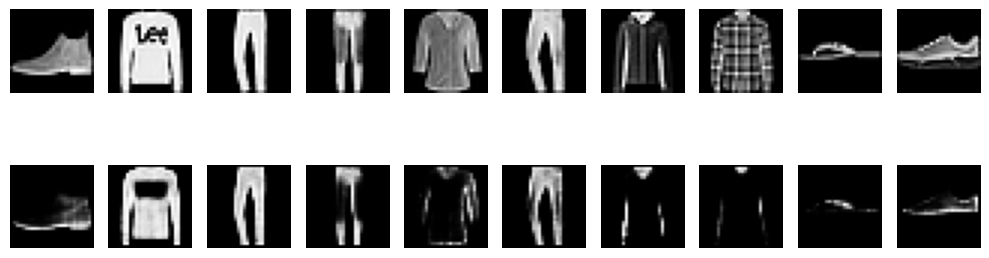

In [12]:
# Visualize Original and Reconstructed Images

n = 10  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

---

Okay now that we have learned these latent representaions let's see if we are able to correctly classify them. For this we will use a SVC.

Now that our autoencoder has learned to compress the input images into their corresponding latent representations, we can use these learned features to classify the images. To evaluate how well these latent embeddings capture the necessary information for classification, we will train a Support Vector Classifier (SVC).

The goal here is to check if the compressed latent space can serve as an effective input for a traditional machine learning classifier (such as SVC in this case). By training the SVC on these embeddings, we can assess whether the autoencoder extracted features allow for accurate classification.

The following code extracts the latent features from the training and test sets using the autoencoder’s encoder block, then trains an SVC model on the extracted embeddings, and finally evaluates the classifier's performance on the test set.

In [ ]:
# First let's verify that the encoder works correctly by checking the shape of its embeddings (should have 64 latent features).
with torch.no_grad():
    for images, _ in test_loader:
        encode = model.encode(images.to(device))
        print(encode.shape)
        break  # Display only one batch

torch.Size([128, 64])


In [17]:
# Train the SVM classifier
X_train = []
y_train = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Extracting Train Features'):
        embeddings = model.encode(images.to(device))
        X_train.append(embeddings.detach().cpu().numpy())
        y_train.append(labels.cpu().numpy())

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

classifier = SVC()
classifier.fit(X_train, y_train)

Extracting Train Features: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]


SVC()

In [18]:
# Test the SVM classifier
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        embeddings = model.encode(images.to(device))
        embeddings = embeddings.detach().cpu().numpy()
        labels = labels.numpy()
        y_pred = classifier.predict(embeddings)

        all_labels.extend(labels)
        all_preds.extend(y_pred)

    print(classification_report(all_labels, all_preds))

100%|██████████| 79/79 [00:28<00:00,  2.80it/s]

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       1.00      0.96      0.98      1000
           2       0.75      0.76      0.76      1000
           3       0.85      0.88      0.86      1000
           4       0.76      0.78      0.77      1000
           5       0.94      0.94      0.94      1000
           6       0.65      0.56      0.60      1000
           7       0.92      0.92      0.92      1000
           8       0.93      0.96      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

